In [1]:
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

In [18]:
def merge_mean(df: pd.DataFrame, next_col_iter: callable) -> pd.DataFrame:
    nd_cols = get_ndvi_columns(df)
    tmp = df.drop(columns=nd_cols)

    curr_idx = 0
    curr_col = nd_cols[0]
    next_col = next_col_iter(nd_cols, curr_col)
    while next_col is not None:
        tmp[f"nd_mean_{curr_idx}"] = df.loc[:, curr_col:next_col].mean(axis=1)
        curr_col = next_col
        next_col = next_col_iter(nd_cols, curr_col)
        curr_idx += 1
    return tmp

def half_month(cols: list[str], curr: str):
    next_col = None

    def dm(col):
        return tuple(map(int, col.split("-")[-2:]))[::-1]

    day_curr, month_curr = dm(curr)

    if day_curr >= 15:
        for c in cols:
            if dm(c)[1] > month_curr:
                next_col = c
                break
    else:
        for c in cols:
            d, m = dm(c)
            if d >= 15 and m == month_curr:
                next_col = c
                break

    if next_col is None and cols.index(curr) != len(cols) - 1:
        return cols[-1]

    return next_col


In [2]:
from src.util import drop_unused_cols, get_ndvi_transformer, get_ndvi_columns

In [3]:
DATA_DIR = "data/"

In [27]:
train_df = pd.read_csv(DATA_DIR + "train_with_reg.csv").set_index("id")
test_df = pd.read_csv(DATA_DIR + "test_with_reg.csv").set_index("id")

In [20]:
# train_df = merge_mean(train_df, half_month)
# test_df = merge_mean(test_df, half_month)

In [28]:
def ndvi_to_int(ndvi: float) -> int:
    if ndvi <= 0:
        return 0
    if ndvi <= 0.2:
        return 1
    if ndvi <= 0.4:
        return 3
    if ndvi <= 0.6:
        return 4
    return 5
    # return int(ndvi * 10)

train_df[get_ndvi_columns(train_df)] = train_df[get_ndvi_columns(train_df)].applymap(ndvi_to_int)
test_df[get_ndvi_columns(test_df)] = test_df[get_ndvi_columns(test_df)].applymap(ndvi_to_int)

In [29]:
X = drop_unused_cols(train_df).drop(["crop"], axis=1)
y = train_df.crop.ravel()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [85]:
X_train.head()

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27
id,,,,,,,,,,,,,,,,,,,,,
5602,3,3,3,3,3,3,3,3,3,1,...,1,1,1,1,1,4,4,1,4,4
5379,3,3,3,3,3,1,1,1,1,1,...,1,1,1,1,3,5,5,3,1,4
3017,3,1,3,1,4,3,1,3,1,3,...,5,4,4,4,4,3,4,1,1,1
2468,3,3,3,3,1,3,1,1,3,1,...,5,4,5,4,1,1,4,1,1,1
3654,3,3,3,3,3,1,3,1,3,1,...,5,3,5,5,4,4,4,1,1,1


In [31]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [32]:
model = CatBoostClassifier(
    learning_rate=0.03,
    random_seed=42,
    loss_function='MultiClass',
    thread_count=2,
    verbose=True,
    eval_metric='Accuracy',
    iterations=2000
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=True
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.5912452	test: 0.6321601	best: 0.6321601 (0)	total: 930ms	remaining: 30m 59s
1:	learn: 0.6208222	test: 0.6397516	best: 0.6397516 (1)	total: 1.76s	remaining: 29m 20s
2:	learn: 0.6225969	test: 0.6432022	best: 0.6432022 (2)	total: 2.61s	remaining: 28m 56s
3:	learn: 0.6302869	test: 0.6473430	best: 0.6473430 (3)	total: 3.56s	remaining: 29m 39s
4:	learn: 0.6394558	test: 0.6597654	best: 0.6597654 (4)	total: 4.47s	remaining: 29m 45s
5:	learn: 0.6530612	test: 0.6639061	best: 0.6639061 (5)	total: 5.33s	remaining: 29m 29s
6:	learn: 0.6580893	test: 0.6652864	best: 0.6652864 (6)	total: 6.18s	remaining: 29m 20s
7:	learn: 0.6595682	test: 0.6687371	best: 0.6687371 (7)	total: 6.99s	remaining: 28m 59s
8:	learn: 0.6619343	test: 0.6687371	best: 0.6687371 (7)	total: 7.85s	remaining: 28m 57s
9:	learn: 0.6628217	test: 0.6708075	best: 0.6708075 (9)	total: 8.65s	remaining: 28m 41s
10:	learn: 0.6634132	test: 0.6721877	best: 0.6721877 (10)	total: 9.53s	remaining: 28m 42s
11:	learn: 0.6657794	test: 0.6

In [42]:
model.get_feature_importance()

array([36.04293508,  0.56044242,  3.31884808,  5.40918437, 10.71270381,
        4.08811521,  1.30022238, 27.71090073,  5.1310828 ,  5.72556513])

Text(0.5, 1.0, 'Feature Importance')

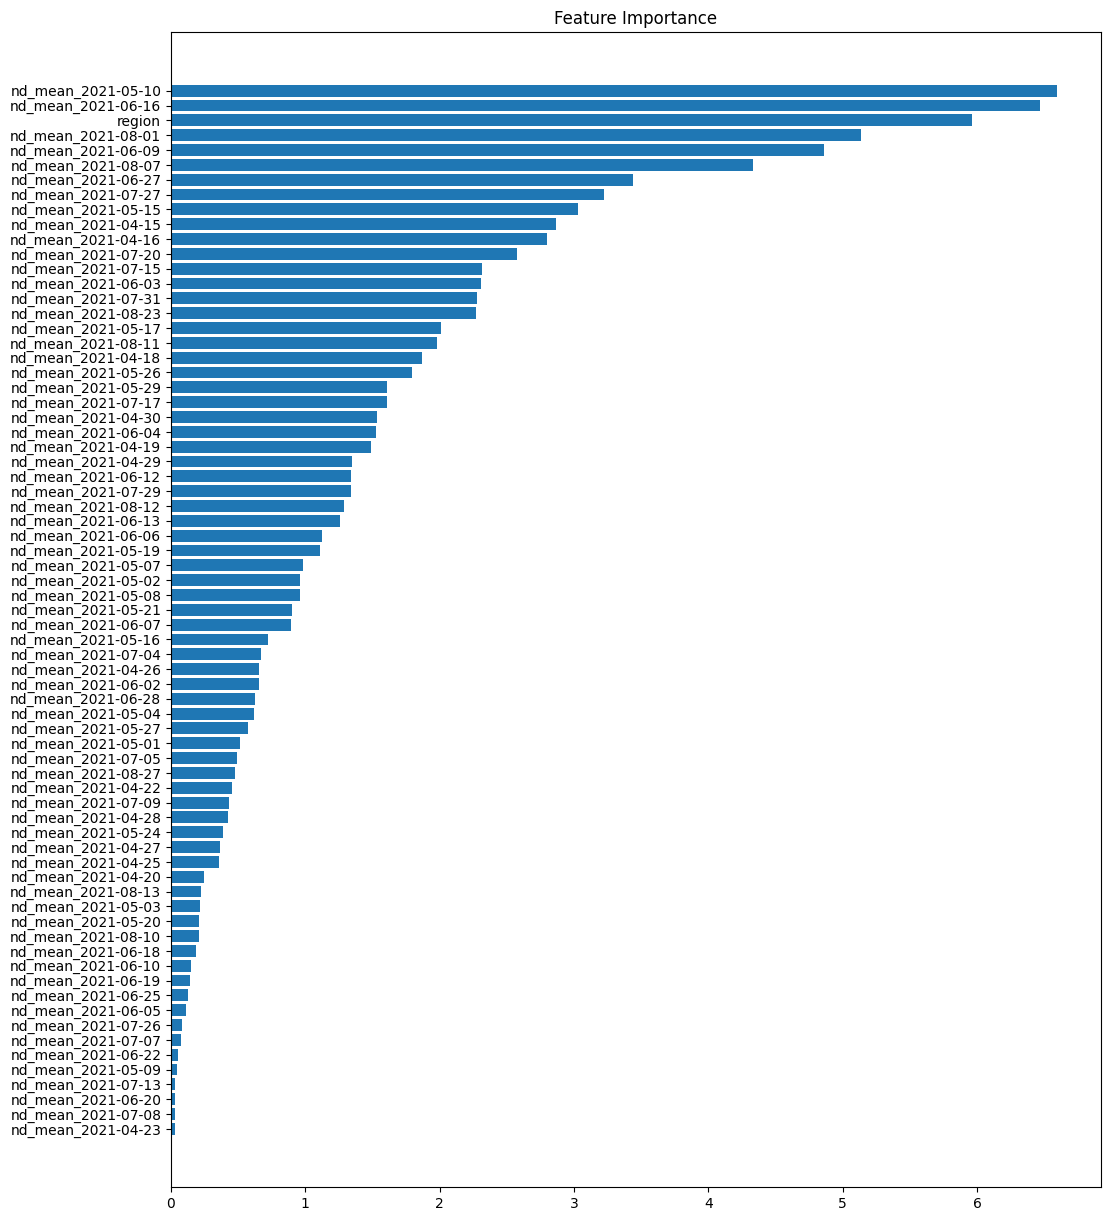

In [33]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [34]:
X_submission = drop_unused_cols(test_df)

In [35]:
y_submission = model.predict(X_submission)

/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [36]:
submission_df = test_df.copy()
submission_df["crop"] = y_submission
submission_df = submission_df[["crop"]]
submission_df.to_csv(DATA_DIR + "submission.csv")

In [38]:
from sklearn.metrics import recall_score

print(recall_score(y_test, model.predict(X_test), average='macro'))

0.9296447987778967


/home/eugen/PycharmProjects/inno-ndvi/venv/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
